In [2]:
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/drive/MyDrive/ML for coders/Deep Learning/Codes/C4/Dataset/transfer/dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


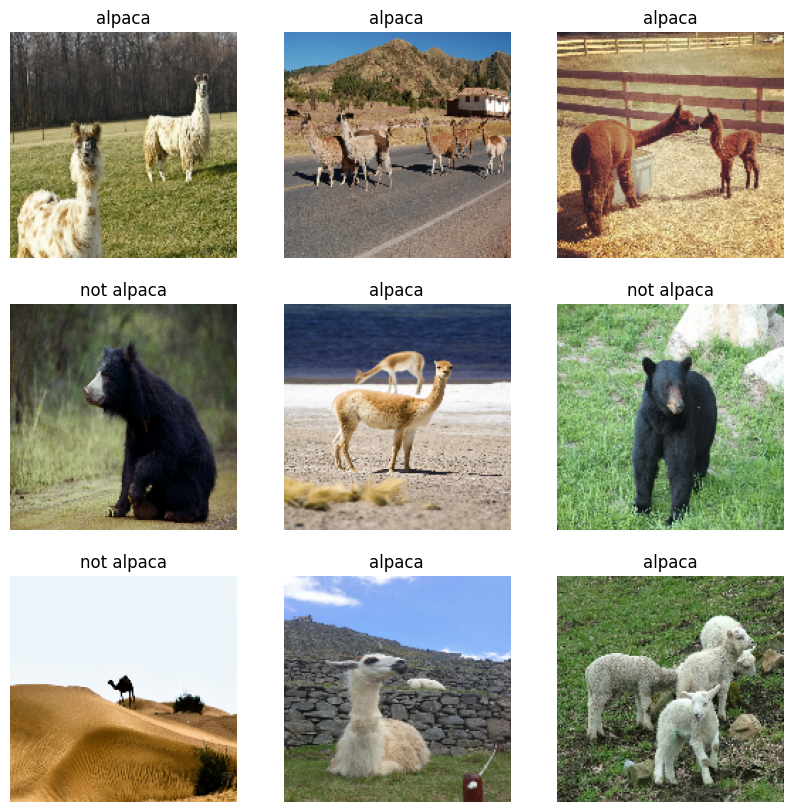

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE

    return data_augmentation

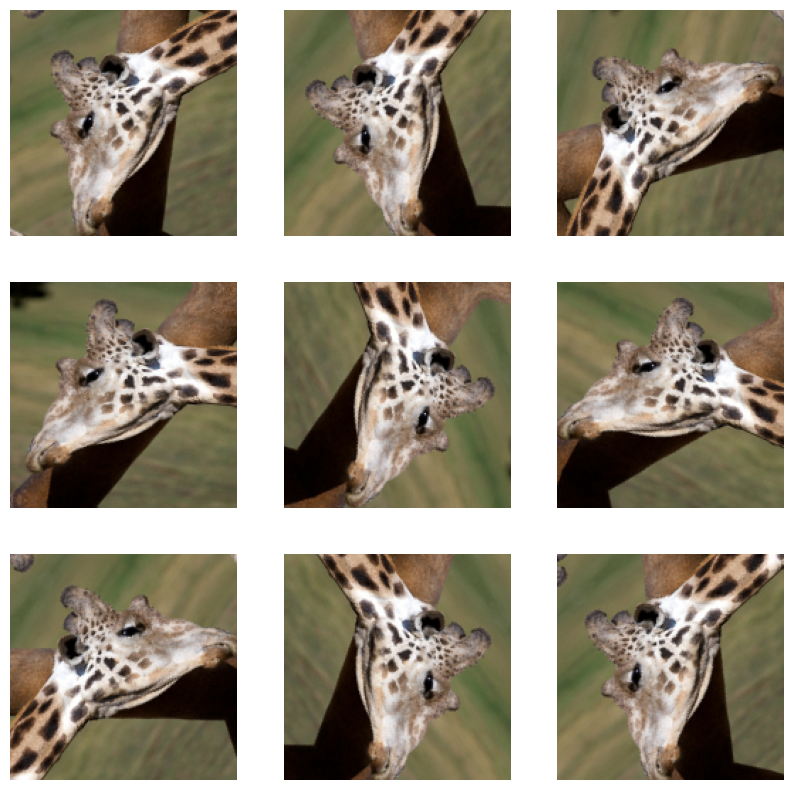

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [12]:
nb_layers = len(base_model.layers)
print(nb_layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

156
global_average_pooling2d
predictions


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [15]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.10329976),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883594)],
 [('n02125311', 'cougar', 0.16546734), ('n02389026', 'sorrel', 0.107642956)],
 [('n02437312', 'Arabian_camel', 0.2923277),
  ('n02437616', 'llama', 0.2771352)],
 [('n03944341', 'pinwheel', 0.31154993), ('n03047690', 'clog', 0.052499976)],
 [('n02454379', 'armadillo', 0.73107195),
  ('n01990800', 'isopod', 0.038719796)],
 [('n02437312', 'Arabian_camel', 0.2566362),
  ('n02422106', 'hartebeest', 0.12122769)],
 [('n02437616', 'llama', 0.6612558),
  ('n02090721', 'Irish_wolfhound', 0.23782833)],
 [('n02133161', 'American_black_bear', 0.8273561),
  ('n02134418', 'sloth_bear', 0.029259538)],
 [('n01518878', 'ostrich', 0.9267558),
  ('n02002724', 'black_stork', 0.0017766341)],
 [('n01518878', 'ostrich', 0.9495457), ('n02018795', 'bustard', 0.0028661576)],
 [('n02437616', 'llama', 0.8699817), ('n02412080', 'ram', 0.07675809)],
 [('n02415577', 'bighorn', 0.24294557), ('n02412080', 'ram', 0.1

In [16]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    ### START CODE HERE

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)

    ### END CODE HERE

    model = tf.keras.Model(inputs, outputs)

    return model

In [17]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [18]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 17s 1s/step - loss: 0.7014 - accuracy: 0.6107 - val_loss: 0.4206 - val_accuracy: 0.8000
Epoch 2/5
9/9 [==============================] - 12s 1s/step - loss: 0.5192 - accuracy: 0.7099 - val_loss: 0.3556 - val_accuracy: 0.7846
Epoch 3/5
9/9 [==============================] - 10s 876ms/step - loss: 0.5396 - accuracy: 0.7099 - val_loss: 0.2899 - val_accuracy: 0.8769
Epoch 4/5
9/9 [==============================] - 13s 941ms/step - loss: 0.4309 - accuracy: 0.7176 - val_loss: 0.2684 - val_accuracy: 0.8769
Epoch 5/5
9/9 [==============================] - 9s 817ms/step - loss: 0.4174 - accuracy: 0.7634 - val_loss: 0.2365 - val_accuracy: 0.9231


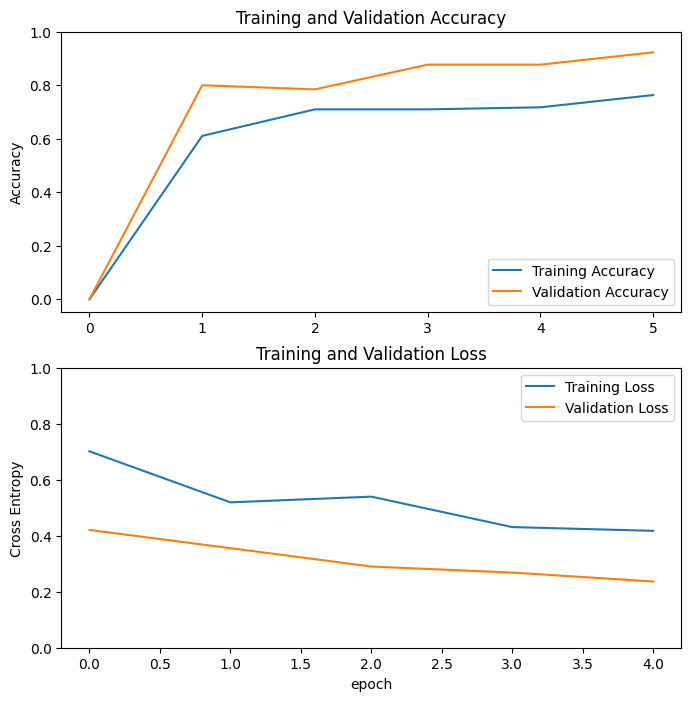

In [20]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
class_names

['alpaca', 'not alpaca']

In [22]:
# UNQ_C3

model2.layers[4].trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in model2.layers[4].layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [23]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 23s 1s/step - loss: 0.5558 - accuracy: 0.7366 - val_loss: 0.2440 - val_accuracy: 0.9846
Epoch 6/10
9/9 [==============================] - 15s 1s/step - loss: 0.3839 - accuracy: 0.8168 - val_loss: 0.2386 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 15s 1s/step - loss: 0.3190 - accuracy: 0.8702 - val_loss: 0.1921 - val_accuracy: 0.8923
Epoch 8/10
9/9 [==============================] - 12s 957ms/step - loss: 0.2373 - accuracy: 0.9008 - val_loss: 0.1211 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 15s 2s/step - loss: 0.1728 - accuracy: 0.9389 - val_loss: 0.0838 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 15s 1s/step - loss: 0.1593 - accuracy: 0.9427 - val_loss: 0.0722 - val_accuracy: 0.9692


In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

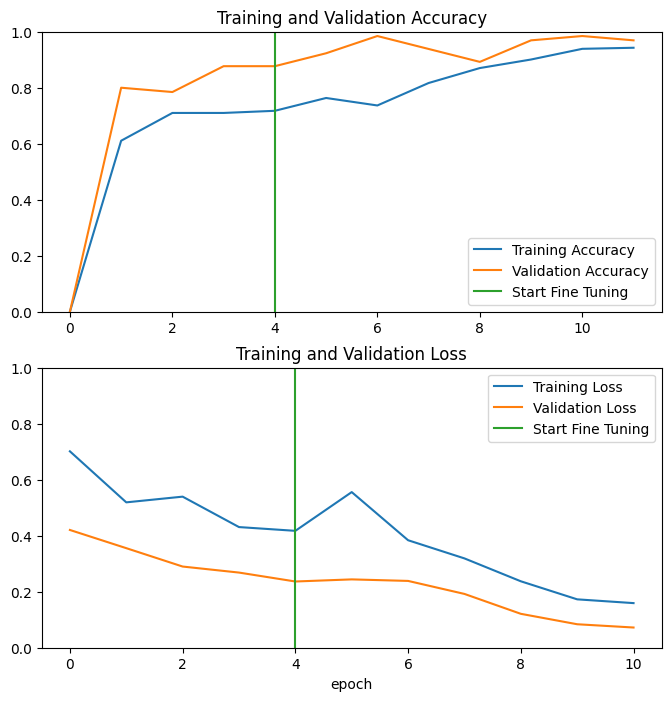

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
model2.layers

In [27]:
model2.layers[4]

In [28]:
test = model2.layers[4]

In [29]:
test.trainable=True

In [30]:
len(test.layers)

154